## Persiapan Semua Bahan

In [ ]:
!pip install google-play-scraper

In [ ]:
!pip install wordCloud

In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google_play_scraper import reviews
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.losses import sparse_categorical_crossentropy
from google_play_scraper import reviews
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

## Scraping aplikasi SeaBank

In [ ]:
result, _ = reviews(
    'id.co.bankbkemobile.digitalbank',
    lang='id',
    country='id',
    count=5000
)

## Data Understanding

In [ ]:
df = pd.DataFrame(result)[['content']]
df.rename(columns={'content':'ulasan'}, inplace=True)

In [ ]:
df.head()

,ulasan,clean_ulasan,sentimen
0,saya penguna aktif di seabank untuk keseluruha...,penguna aktif seabank seluruh seabank sangat b...,positif
1,cepattt,cepattt,netral
2,baik,baik,positif
3,sangat membantu,sangat bantu,positif
4,baik,baik,positif


In [ ]:
df.shape

(5000, 1)

## Preprocessing

In [ ]:
stemmer = StemmerFactory().create_stemmer()

In [ ]:
slang_dict = {
    # 1. Kata Ganti Orang / Sapaan
    "kmu": "kamu",
    "aq": "aku",
    "gw": "saya",
    "loe": "kamu",
    "lu": "kamu",
    "gua": "saya",
    "ane": "saya",
    "ente": "kamu",
    "gan": "juragan",
    "sis": "kakak perempuan",
    "sist": "kakak perempuan",
    "bro": "saudara laki-laki",
    "bos": "atasan",
    "min": "admin",


    "bgt": "banget",
    "gpp": "tidak apa-apa",
    "jd": "jadi",
    "gk": "tidak",
    "ga": "tidak",
    "ngga" : "tidak",
    "tdk": "tidak",
    "jg": "juga",
    "trs": "terus",
    "dngn": "dengan",
    "sya": "saya",
    "bsa": "bisa",
    "skrg": "sekarang",
    "bkn": "bukan",
    "udh": "sudah",
    "sdh": "sudah",
    "tp": "tapi",
    "krn": "karena",
    "td": "tadi",
    "knp": "kenapa",
    "dpt": "dapat",
    "mnrt": "menurut",
    "dlm": "dalam",
    "smua": "semua",
    "trsbh": "tersebut",
    "ajh": "saja",
    "aja": "saja",
    "sj": "saja",
    "kl": "kalau",
    "klo": "kalau",
    "dr": "dari",
    "utk": "untuk",
    "bgmn": "bagaimana",
    "sm": "sama",
    "sampe": "sampai",
    "smpe": "sampai",
    "bgs": "bagus",

    "bagusss": "bagus",
    "murahhh": "murah",
    "mantul": "mantap betul",
    "mrh": "marah",
    "wkwk": "tertawa",
    "lol": "tertawa terbahak-bahak",
    "poko nya": "pokoknya",
    "pokonya": "pokoknya",
    "pkonya": "pokoknya",
    "trmks": "terima kasih",
    "smg": "semoga",
    "yg" : "yang",


    "baper": "terbawa perasaan",
    "mager": "malas gerak",
    "gabut": "tidak ada kerjaan",
    "santuy": "santai",
    "gaje": "tidak jelas",
    "woles": "tenang",
    "otw": "sedang dalam perjalanan",
    "btw": "ngomong-ngomong",
    "kuy": "ayo",
    "cmiiw": "koreksi jika saya salah",
    "asap": "secepat mungkin",
    "japri": "jalur pribadi",
    "rekber": "rekening bersama",
    "bocil": "bocah kecil",
    "vibes": "suasana",
    "spill": "membocorkan",
    "ghosting": "menghilang tanpa kabar",
    "flexing": "pamer",
    "cringe": "memalukan",
    "ngegas": "marah",
    "nolep": "tidak memiliki kehidupan sosial",
    "halu": "halusinasi",
    "brb": "akan segera kembali",
    "pgn": "ingin",
    "nyebelin": "menyebalkan",


    "apl": "aplikasi",
    "aplkasi": "aplikasi",
    "fitur2": "fitur-fitur",
    "trans": "transaksi",
    "tf": "transfer",
    "mbanking": "mobile banking",
    "bank": "bank",
    "rek": "rekening",
    "ktp": "kartu tanda penduduk",
    "akun": "akun",
    "akunya": "akun",
    "admin": "administrator",
    "error": "kesalahan",
    "eror": "kesalahan",
    "lemot": "lambat",
    "pending": "tertunda",
    "verif": "verifikasi",
    "kyk": "seperti",
    "kyknya": "sepertinya",
    "tmbhn": "tambahan",

    "akn": "akan",
    "bnr": "benar",
    "bener": "benar",
    "kmn": "kemana",
    "gmna": "bagaimana",
    "mkn": "makan",
    "mnum": "minum",
    "klr": "keluar",
    "bljr": "belajar",
    "trus": "terus",
    "bbrp": "beberapa",
    "trm ksh": "terima kasih",
    "trima kasih": "terima kasih",
    "mksh": "terima kasih",
    "makasih": "terima kasih",
    "gatau": "tidak tahu",
    "gatahu": "tidak tahu",
    "baper": "terbawa perasaan",
    "mager": "malas gerak",
    "gabut": "tidak ada kerjaan",
    "santuy": "santai",
    "gaje": "tidak jelas",
    "woles": "tenang",
    "otw": "sedang dalam perjalanan",
    "cmiiw": "koreksi jika saya salah",
    "asap": "secepat mungkin",
    "mantul": "mantap betul",
    "rekber": "rekening bersama",
    "spill": "membocorkan",
    "ghosting": "menghilang tanpa kabar",
    "flexing": "pamer",
    "wkwk": "tertawa",
    "brb": "akan segera kembali",
    "gk" : "tidak",
    "ga" : "tidak",
    "tdk" : "tidak",
    "murahhh":"murah",
    "mnatap" : "mantap",
    "adm" : "admin",
    "sangan" : "sangat",
    "goof" : "good",
    "smoga" : "semoga",
    "trmksh" : "terima kasih",
    "dgn" : "dengan",
    "apk" : "aplikasi",
    "ra" : "tidak",
    "Ra" : "tidak",
    "jls" : "jelas",
    "gambang": "mudah",
    "nmr" : "nomor",
    "klw" : "kalau"


}

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Inisialisasi Stop Word Remover
factory = StopWordRemoverFactory()
stopword_sastrawi = factory.get_stop_words()

# Tambahkan custom stop words
custom_stop_words = [
    "saya", "di", "ke", "dari", "yang", "dan", "atau", "adalah",
    "merupakan", "untuk", "buat", "itu", "ini","dengan", "juga",
    "sudah", "udah", "aja", "nya","aplikasi"
]

# Gabungkan stop words
all_stop_words = set(stopword_sastrawi)
all_stop_words.update(custom_stop_words)


def clean_text(text):
  text = text.lower() # Lowercasing
  text = re.sub(r'\d+', '', text)  # Hapus angka
  text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
  # Normalisasi Slang
  text = ' '.join([slang_dict[word] if word in slang_dict else word for word in text.split()])
  # Stemming
  text = stemmer.stem(text)
  # Penghapusan Stop Words
  text = ' '.join([word for word in text.split() if word not in all_stop_words])
  return text

In [ ]:
df['clean_ulasan'] = df['ulasan'].apply(clean_text)

In [ ]:
df.head()

,ulasan,clean_ulasan
0,saya penguna aktif di seabank untuk keseluruha...,penguna aktif seabank seluruh seabank sangat b...
1,cepattt,cepattt
2,baik,baik
3,sangat membantu,sangat bantu
4,baik,baik


In [ ]:
#Labeling Sentimen Berdasarkan Kata-kata Positif,Netral dan Negatif
positive_words = ["bagus", "mantap", "cepat", "puas", "senang", "baik", "suka", "gampang", "mudah","lebih mudah",
                  "serba mudah", "keren", "menarik", "membantu", "praktis", "top", "terbaik", "bantu", "puas", "memuaskan",
                  "manfaat", "cocok","lancar", "responsif", "efisien", "ok", "terjamin", "istimewa", "solusi","hemat",
                  "untung", "menguntungkan", "sukses", "berhasil", "recommended","gratis", "free", "bunga", "tinggi", "cair", "cairkan",
                  "bonus", "hadiah", "promosi","promo", "mudah", "simpel", "fitur", "lengkap","good","terjangkau","alhamdulillah",
                  "recommend ", "amanah", "aman"
                  ]

negative_words = ["buruk", "lama", "error", "jelek", "lelet", "kecewa", "penipuan", "blokir","eror", "kurang", "berat",
                  "bego", "lambat", "susah", "masalah", "banget","gagal", "kendala", "sulit", "ribet", "lag", "hang", "crash", "bug",
                  "rusak","macet", "putus", "keluar", "tertunda", "pending", "payah", "menyebalkan", "sampah", "buang", "uninstall",
                  "muter", "ngecas", "bobol", "hilang", "akun", "terkunci", "verifikasi", "gagal", "suspend", "diblokir", "padahal", "kenapa",
                  "tolong",  "parah","tolol","salah",
                  ]

netral_words = [  "debit", "kredit", "atm", "bank", "mandiri", "sinyal","app", "mobile",
                "digital", "transfer", "tarik", "setor", "rekening", "saldo", "nominal", "jumlah", "transaksi", "dana", "customer", "service",
                 "cs", "admin", "fitur", "menu", "layar", "login", "password", "pin", "otp","email", "nomor", "telepon", "handphone", "hp", "data",
                 "upload", "download", "verifikasi", "proses", "seabank", "shopeepay", "shopee", "uang", "cuma", "hanya", "padahal", "saat", "waktu",
                 "kalau", "karena", "tersebut", "terbaru", "sekarang",]




In [ ]:

def sentimen_label(text):

  pos_count = sum(1 for word in text.split() if word in positive_words)
  netral_count = sum(1 for word in text.split() if word in netral_words)
  neg_count = sum(1 for word in text.split() if word in negative_words)

  if pos_count > neg_count:
    return 'positif'
  elif pos_count < neg_count:
    return 'negatif'
  else :
    return 'netral'

In [ ]:
df ['sentimen'] = df['clean_ulasan'].apply (sentimen_label)

In [ ]:
df.head()

,ulasan,clean_ulasan,sentimen
0,saya penguna aktif di seabank untuk keseluruha...,penguna aktif seabank seluruh seabank sangat b...,positif
1,cepattt,cepattt,netral
2,baik,baik,positif
3,sangat membantu,sangat bantu,positif
4,baik,baik,positif


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ulasan        5000 non-null   object
 1   clean_ulasan  5000 non-null   object
 2   sentimen      5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [ ]:
df['sentimen'].value_counts()

,count
sentimen,
positif,3338
netral,1361
negatif,301


  Sentimen  Frekuensi  Persentase
0  positif       3338       66.76
1   netral       1361       27.22
2  negatif        301        6.02


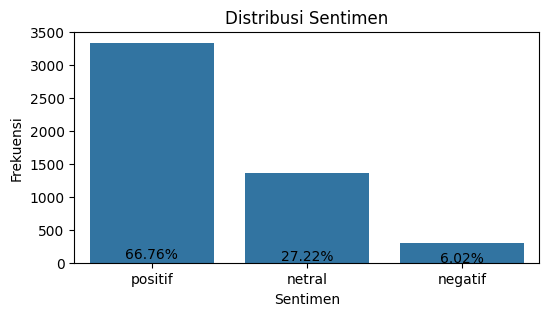

In [ ]:
#membuat visualisasi pada sentimen
sentimen_counts = df['sentimen'].value_counts()
sentimen_percentage = sentimen_counts / len(df) * 100
sentimen_df = pd.DataFrame({'Sentimen': sentimen_counts.index, 'Frekuensi': sentimen_counts.values, 'Persentase': sentimen_percentage.values})
print(sentimen_df)

plt.figure(figsize=(6, 3))
sns.barplot(x='Sentimen', y='Frekuensi', data=sentimen_df)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Frekuensi')

for i, v in enumerate(sentimen_percentage.values):
    plt.text(i, v + 5, f'{v:.2f}%', ha='center')

plt.show()

In [ ]:
df.iloc[500:]

,ulasan,clean_ulasan,sentimen
500,enk banget pake seabank,enk banget pake seabank,negatif
501,"sungguh sangat² membantu, tetap amanah",sungguh sangat bantu tetap amanah,positif
502,puasss bngettttt,puasss bngettttt,netral
503,mantap sanget enak nyaman aman,mantap sanget enak nyaman aman,positif
504,bestt,bestt,netral
...,...,...,...
4995,mantap banget,mantap banget,netral
4996,"Saya ingin menutup rekening, tapi dipersulit, ...",tutup rekening sulit ganti nomor telepon sulit...,netral
4997,berguna.,,netral
4998,seapinjam belom muncul muncul nih,seapinjam bom muncul muncul nih,netral


In [ ]:

#konversi teks ke vektor (Tokenisasi & Padding)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_ulasan'])
X = tokenizer.texts_to_sequences(df['clean_ulasan'])
X = pad_sequences(X, maxlen=50) #Padding Sequences

In [ ]:
list_label =[]
for label in df['sentimen']:
    if label == 'positif':
        list_label.append(0)
    elif label == 'netral':
        list_label.append(1)
    else:
         list_label.append(2)

In [ ]:
y=np.array(list_label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Melatih Model

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=50),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(32,activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6560 - loss: 0.7632 - val_accuracy: 0.9400 - val_loss: 0.1743
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9447 - loss: 0.1661 - val_accuracy: 0.9690 - val_loss: 0.0845
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9802 - loss: 0.0655 - val_accuracy: 0.9750 - val_loss: 0.0756
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9906 - loss: 0.0354 - val_accuracy: 0.9700 - val_loss: 0.0837
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9926 - loss: 0.0278 - val_accuracy: 0.9700 - val_loss: 0.0988


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)
print(classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       669
           1       0.94      0.95      0.95       268
           2       0.95      0.84      0.89        63

    accuracy                           0.97      1000
   macro avg       0.96      0.93      0.94      1000
weighted avg       0.97      0.97      0.97      1000



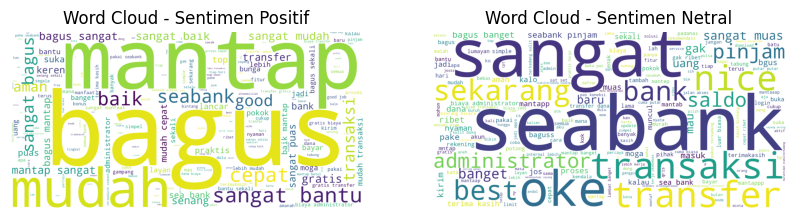

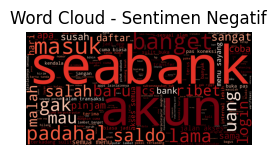

In [ ]:
#  Visualisasi Word Cloud (Positif & Negatif)
pos_text = ' '.join(df[df['sentimen'] == 'positif']['clean_ulasan'])
net_text = ' '.join(df[df['sentimen'] == 'netral']['clean_ulasan'])
neg_text = ' '.join(df[df['sentimen'] == 'negatif']['clean_ulasan'])

wordcloud_pos = WordCloud(width=2000, height=1000, background_color='white').generate(pos_text)
wordcloud_net = WordCloud(width=2000, height=1000, background_color='white').generate(net_text)
wordcloud_neg = WordCloud(width=2000, height=1000, background_color='black', colormap='Reds').generate(neg_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.title("Word Cloud - Sentimen Positif")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_net)
plt.axis("off")
plt.title("Word Cloud - Sentimen Netral")
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.title("Word Cloud - Sentimen Negatif")
plt.show()